In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt
from sqlalchemy import create_engine
import pickle

sns.set()
sns.set(rc={'figure.figsize':(10,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

In [4]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import AccDistIndexIndicator
from ta.volatility import AverageTrueRange

# Preparation: Pickle

In [5]:
def save_pickle(data,filename):
    with open(filename, 'wb') as fp:
        pickle.dump(data, fp, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Saved {filename}!')

def load_pickle(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp)
    print(f'Load {filename}!')
    return data

# Preparation: Evaluator

In [2]:
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()/self.fourFactor['Strategy-RF'].std()*np.sqrt(252)
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

# Preparation: data

## Yfinance

In [6]:
class DataLib:
    def __init__(self,symbols=list(),interval='1d'):
        self.max_len = 0
        self.symbols = symbols
        self.interval = interval
        self.data = dict()
        self.train_data = dict()
        self.test_data = dict()

    def download_yf(self):
        for symbol in self.symbols:
            data = yf.download(symbol,
                               interval=self.interval).loc[:,['Open','High','Low','Close']]
            self.max_len = max(self.max_len, len(data))
            self.data[symbol] = data

    def set_data(self,symbol,data):
        self.symbols.append(symbol)
        self.data[symbol] = data

    def get(self,symbol):
        return self.data[symbol]
    
    def split_train(self,frac=0.6,spill=0.005):
        for symbol in self.symbols:
            data = self.get(symbol)
            train_end = round(len(data) * frac - spill)
            test_start = round(len(data) * frac)
            self.train_data[symbol] = data.iloc[:train_end]
            self.test_data[symbol] = data.iloc[test_start:]

    def get_train(self,symbol):
        return self.train_data[symbol]
    
    def get_test(self,symbol):
        return self.test_data[symbol]

    def pool(data_list):
        return pd.concat(data_list,axis=0)

In [7]:
symbols = ['EURUSD=X','JPY=X','GBPUSD=X','CHF=X','AUDUSD=X','CAD=X','NZDUSD=X']

data = DataLib(symbols,'1d')
data.download_yf()
data.split_train()

#symbols = symbols + ['CHFJPY=X','EURGBP=X','EURCAD=X','EURAUD=X','EURJPY=X','EURNZD=X','EURCHF=X','GBPCHF=X','GBPJPY=X','CADCHF=X','CADJPY=X','GBPAUD=X','GBPCAD=X','GBPNZD=X','NZDCAD=X','NZDCHF=X','NZDJPY=X']
           
#data = dict()
#for symbol in symbols:
#    data[symbol] = yf.download(symbol,interval='1d').loc[:,['Open','High','Low','Close','Volume']]
#    data[symbol].to_csv(f'data/yfinance/{symbol}.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Minute DB

In [130]:
symbols = ['EURUSD','USDJPY','GBPUSD','USDCHF','AUDUSD','USDCAD','NZDUSD']

db_url = 'sqlite:///data/minute_data/fx_min_data.db'
db_engine = create_engine(db_url, echo=False)

data = dict()
for symbol in symbols:
    query = f'''
SELECT "Datetime","Open","High","Low","Close","Volume" FROM {symbol}
WHERE Datetime >= "2000-01-01"
ORDER BY Datetime ASC
'''
    data[symbol] = pd.read_sql( query,db_engine,
                                index_col='Datetime')
db_engine.dispose()

In [131]:
for symbol in symbols:
    df = data[symbol]
    df.index = pd.to_datetime(df.index)

In [132]:
def get_daily(df):
    o,h,l,c,v = df['Open'],df['High'],df['Low'],df['Close'],df['Volume']
    try:
        o = o[0]
        h = h.max()
        l = l.min()
        c = c[-1]
        return df.iloc[-1]
    except:
        return

In [133]:
for symbol in symbols:
    data[symbol] = data[symbol].resample('D').apply(get_daily).dropna()

## AlphaVantage

In [4]:
API_KEY = 'W3JAKQ6WP4ZSD8QY'
symbols = ['EUR/USD','USD/JPY','GBP/USD','USD/CHF','AUD/USD','USD/CAD','NZD/USD']
data = dict()
for symbol in symbols:
    fx_reader = pdr.av.time_series.AVTimeSeriesReader(symbols=symbol, function='FX_DAILY',retry_count=3, pause=0.1, session=None, api_key=API_KEY)
    data[symbol] = fx_reader.read()

In [5]:
for symbol in symbols:
    data[symbol].columns = data[symbol].columns.map(lambda s: s.capitalize())

# ATR Forecasting with OLS

In [314]:
def add_atr(df):
    df = df.copy()

    o,h,l,c = df['Open'],df['High'],df['Low'],df['Close']
    
    df['lead_ATR_1'] = AverageTrueRange(h,l,c,1).average_true_range().shift(-1)#.diff()
    #df['mATR_1'] = AverageTrueRange(h,l,c,1).average_true_range().diff().rolling(5).mean()

    for i in [1,10,15,20]:
        df[f'ATR_{i}'] = AverageTrueRange(h,l,c,i).average_true_range()
        #df[f'dATR_{i}'] = df[f'ATR_{i}'] - df[f'ATR_{i}'].rolling(i*5).mean()
        #df.drop(columns=f'ATR_{i}',inplace=True)
    #for i in [1,2,15,20]:
    #    df[f'dATR_{i}'] = AverageTrueRange(h,l,c,i).average_true_range().diff()

    return df.drop(columns=['Open','High','Low','Close','Volume'])

In [315]:
train_list = list()
for symbol in data.symbols:
    train_data = add_atr(data.get_train(symbol))
    train_list.append(train_data)
reg_df = DataLib.pool(train_list)

In [316]:
reg_df.dropna(inplace=True)
y = reg_df['lead_ATR_1']
x = reg_df.drop(columns=('lead_ATR_1'))
model = sm.OLS(y,x)
result = model.fit()

In [317]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             lead_ATR_1   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.755
Method:                 Least Squares   F-statistic:                          1.755e+04
Date:                Fri, 09 Feb 2024   Prob (F-statistic):                        0.00
Time:                        03:39:38   Log-Likelihood:                         -4804.0
No. Observations:               22815   AIC:                                      9616.
Df Residuals:                   22811   BIC:                                      9648.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ATR_1          0.3181      0.007     42.641      0.000       0.303       0.333
ATR_10        -0.1594      0.091     -1.749      0.080      -0.338       0.019
ATR_15         0.5147      0.189      2.728      0.006       0.145       0.884
ATR_20         0.3143      0.118      2.666      0.008       0.083       0.545
==============================================================================
Omnibus:                    41508.587   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        240345363.647
Skew:                          12.820   Prob(JB):                         0.00
Kurtosis:                     505.167   Cond. No.                         125.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [318]:
params = result.params
print(params)
save_pickle(params,'models/params/atr_weight.pkl')

ATR_1     0.318089
ATR_10   -0.159364
ATR_15    0.514663
ATR_20    0.314290
dtype: float64
Saved models/params/atr_weight.pkl!


In [319]:
atr_weight = load_pickle('models/params/atr_weight.pkl')

Load models/params/atr_weight.pkl!


0.8468933305342987


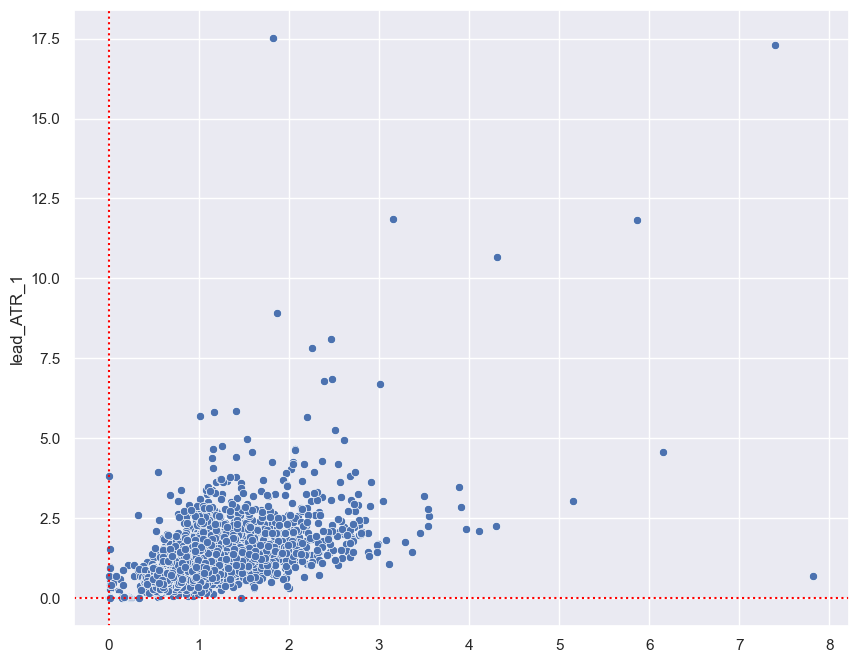

In [320]:
y = reg_df['lead_ATR_1']
x = reg_df.drop(columns=('lead_ATR_1')).mul(atr_weight,axis=1).sum(axis=1)

print(y.corr(x))

ax = sns.scatterplot(y=y, x=x)
ax.axhline(0,color='red',linestyle=':')
ax.axvline(0,color='red',linestyle=':')

0.870066531938971


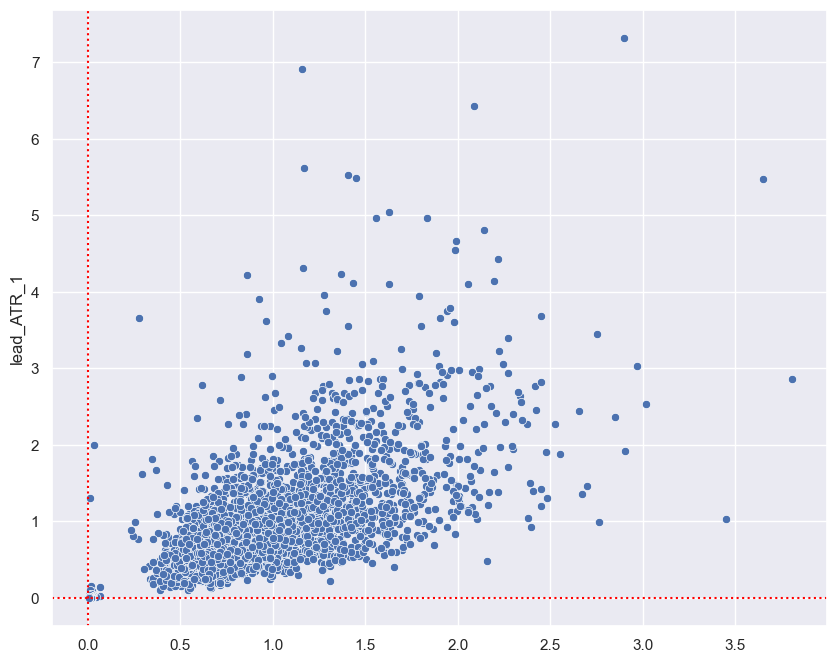

In [321]:
test_list = list()
for symbol in data.symbols:
    test_data = add_atr(data.get_test(symbol))
    test_list.append(test_data)
df = DataLib.pool(test_list).dropna()

y = df['lead_ATR_1']
x = df.drop(columns=('lead_ATR_1')).mul(atr_weight,axis=1).sum(axis=1)

print(y.corr(x))

ax = sns.scatterplot(y=y, x=x)
ax.axhline(0,color='red',linestyle=':')
ax.axvline(0,color='red',linestyle=':')

# MACD RSI strategy

In [8]:
def cusum_filter(series,h):
    t,s_pos,s_neg = [],0,0
    diff = series.diff().dropna()
    for i in diff.index[1:]:
        s_pos,s_neg = max(0,s_pos+diff.loc[i]),min(0,s_neg+diff.loc[i])
        if s_neg < -h.loc[i]:
            s_neg = 0; t.append(i)
        elif s_pos > h.loc[i]:
            s_pos = 0; t.append(i)
    return pd.DatetimeIndex(t)

In [37]:
def add_ta_signals(df):
    df = df.copy()

    o,h,l,c = df['Open'],df['High'],df['Low'],df['Close']
    

    atr = pd.DataFrame()
    for i in [1,10,15,20]:
        atr[f'ATR_{i}'] = AverageTrueRange(h,l,c,i).average_true_range()
    atr_weight = load_pickle('models/params/atr_weight.pkl')
    comb_atr = atr.mul(atr_weight,axis=1).sum(axis=1)
    df['ATR'] = comb_atr

    df['Ret_ATR'] = c.diff().shift(-1)/comb_atr
    #df['Pos'] = np.zeros(len(df))
    #df['Pos'].loc[ret < -comb_atr] = -1
    #df['Pos'].loc[ret > comb_atr] = 1
    
    #for i in [5,10,20,40,80,160]:
    #    macd = MACD(c,i,i*4,i*2).macd_diff().div(comb_atr,axis=0)
    #    df[f'MACD_{i}'] = macd

    #for i in range(2,21):
    #    rsi = RSIIndicator(c,i).rsi()#.div(comb_atr,axis=0)
    #    df[f'RSI_{i}'] = rsi

    idx = cusum_filter(df['Close'],comb_atr)
    df['Trend'] = np.sign(df['Close'].loc[idx].diff())
    df['Trend'] = df['Trend'].ffill()

    return df.drop(columns=['Open','High','Low','Close'])#.loc[idx]

In [38]:
ta_data = DataLib()
for symbol in symbols:
    ta = add_ta_signals(data.get(symbol)).dropna()
    ta_data.set_data(symbol,ta)
ta_data.split_train()

Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!
Load models/params/atr_weight.pkl!


In [151]:
def get_pos(df,tp_atr=None,sl_atr=None,hold_day=None):
    trend,ret,atr = df['Trend'],df['Ret_ATR'],df['ATR']

    if tp_atr is None:
        tp = pd.Series(np.inf,index=df.index)
    else:
        tp = tp_atr * atr

    if sl_atr is None:
        sl = pd.Series(-np.inf,index=df.index)
    else:
        sl = sl_atr * atr

    if hold_day is None:
        hold = pd.Series(np.inf,index=df.index)
    else:
        hold = pd.Series(hold_day,index=df.index)

    pos = pd.Series(np.zeros(len(df)),index=df.index)
    pos.iloc[0] = trend.iloc[0]
    hit = False
    cum_ret = 0
    day = 0
    for i in range(1,len(df)):
        # hold if last bar didnt hit tp/sl
        if not hit:
            pos.iloc[i] = pos.iloc[i-1]
            cum_ret += pos.iloc[i] * ret.iloc[i]
            day += 1
        # reset if trend reverse
        elif trend.iloc[i-1] != trend.iloc[i]:
            pos.iloc[i] = trend.iloc[i]
            cum_ret = pos.iloc[i] * ret.iloc[i]
            day = 1
            hit = False
        # reset if barrier is hit and trend continues
        else:
            pos.iloc[i] = 0
            cum_ret = 0
            day = 0

        if (cum_ret>=tp.iloc[i]) or (cum_ret<=sl.iloc[i]) or (day>=hold.iloc[i]):
            hit = True
            cum_ret = 0
            day = 0
    return pos
            

In [ ]:
ta_data.get_train(symbol)['Ret_ATR'].loc[ta_data.get_train(symbol)['Ret_ATR']<0].plot()

In [173]:
symbol = 'EURUSD=X'
hmap = pd.DataFrame(index=pd.Series(np.arange(50,105,5),name='TP'),
                    columns=pd.Series(np.arange(1,11,1),name='SL'))
ret = np.log(data.get_train(symbol)['Close']).diff().shift(-1)
for tp in hmap.index:
    for sl in hmap.columns:
        pos = get_pos(ta_data.get_train(symbol),
                        tp_atr=tp,
                        sl_atr=sl,
                        hold_day=21)
        pnl = (pos * ret)
        pf = pnl.mean()/pnl.std() *252**0.5
        hmap.loc[tp,sl] = pf

<Axes: xlabel='SL', ylabel='TP'>

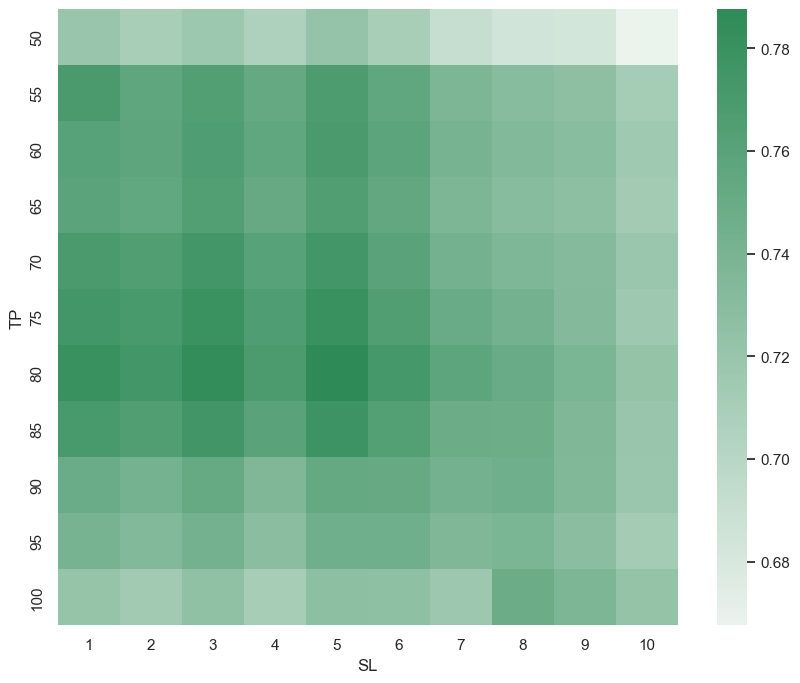

In [174]:
sns.heatmap(hmap.astype(float),cmap=SNS_CMAP)

In [521]:
train_list = list()
for symbol in symbols:
    train_list.append(ta_data.get_train(symbol))
pooled = DataLib.pool(train_list)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X=pooled.drop(columns='Pos'),
       y=pooled['Pos'])

<Axes: xlabel='Date'>

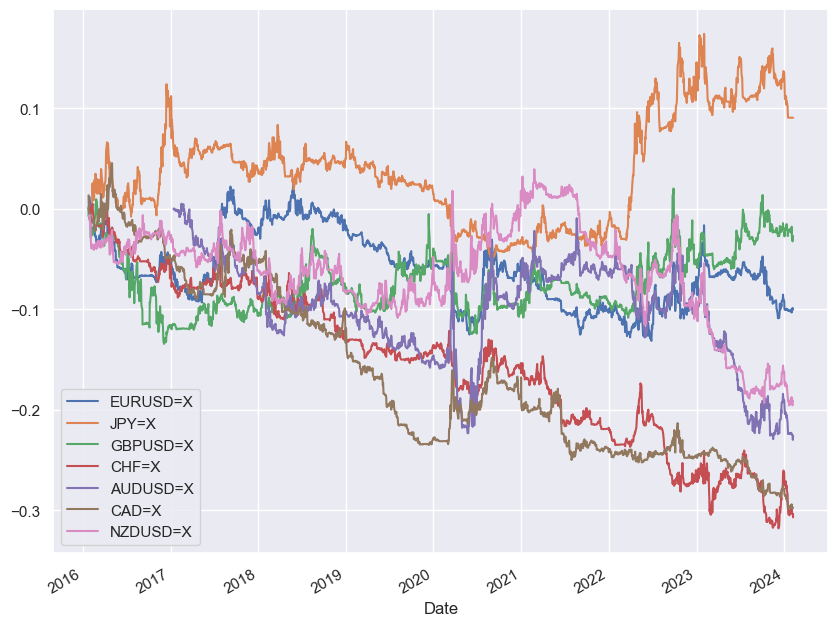

In [523]:
pnl = pd.DataFrame()
for symbol in symbols:
    pos = ta_data.get_test(symbol)['EMA']
    #features = ta_data.get_test(symbol).drop(columns='Pos')
    #pos = pd.Series(rf.predict(X=features),index=features.index)
    ret = np.log(data.get_test(symbol)['Close']).diff().shift(-1)
    pnl[symbol] = pos * ret
pnl.cumsum().plot()

<Axes: >

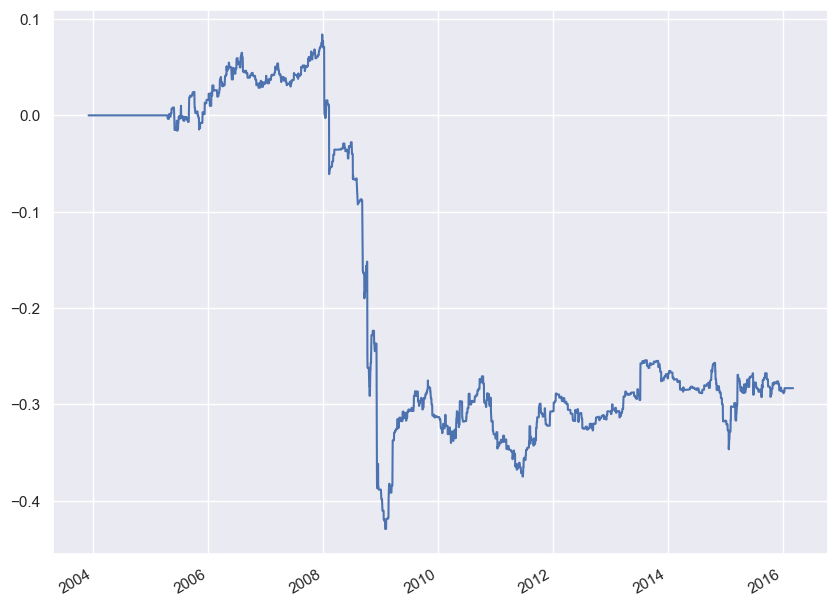

In [427]:
pos = pd.Series(knn.predict(ta_data.get_train('EURUSD=X').drop(columns='Pos')),index=ta_data.get_train('EURUSD=X').index)
ret = np.log(data.get_train('EURUSD=X')['Close']).diff().shift(-1)
pnl = (pos * ret).fillna(0)

pnl.cumsum().plot()

# KNN Model

### Back-testing

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=1,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
                y=np.sign(bootstrap_train_data.iloc[:,0]))

In [92]:
#symbols = ['EURUSD=X','JPY=X','GBPUSD=X','CHF=X','AUDUSD=X','CAD=X','NZDUSD=X']
#symbols = ['CHFJPY','EURGBP','EURCAD','EURAUD','EURJPY','EURNZD','EURCHF','GBPCHF','GBPJPY','CADCHF','CADJPY','GBPAUD','GBPCAD','GBPNZD','NZDCAD','NZDCHF','NZDJPY']
for symbol in symbols:
    df = test_data[symbol]
    pos = pd.DataFrame()
    for i,knn in enumerate(knns):
        pos[f'{i}'] = knn.predict(df.iloc[:,1:])
    df['Pred'] = pos.mean(axis=1).to_numpy()
    df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
    df['Pnl'] = df['Pos'] * df['Ret']

C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1727795900.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = pos.mean(axis=1).to_numpy()
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1727795900.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1727795900.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [93]:
for symbol in symbols:
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s
    print(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

EUR/USD (m=-1.77% s=4.48% SR = -0.40)
USD/JPY (m=7.97% s=5.12% SR = 1.56)
GBP/USD (m=-4.59% s=4.66% SR = -0.99)
USD/CHF (m=4.80% s=4.64% SR = 1.03)
AUD/USD (m=-0.21% s=5.82% SR = -0.04)
USD/CAD (m=1.75% s=2.87% SR = 0.61)
NZD/USD (m=-3.18% s=5.54% SR = -0.57)


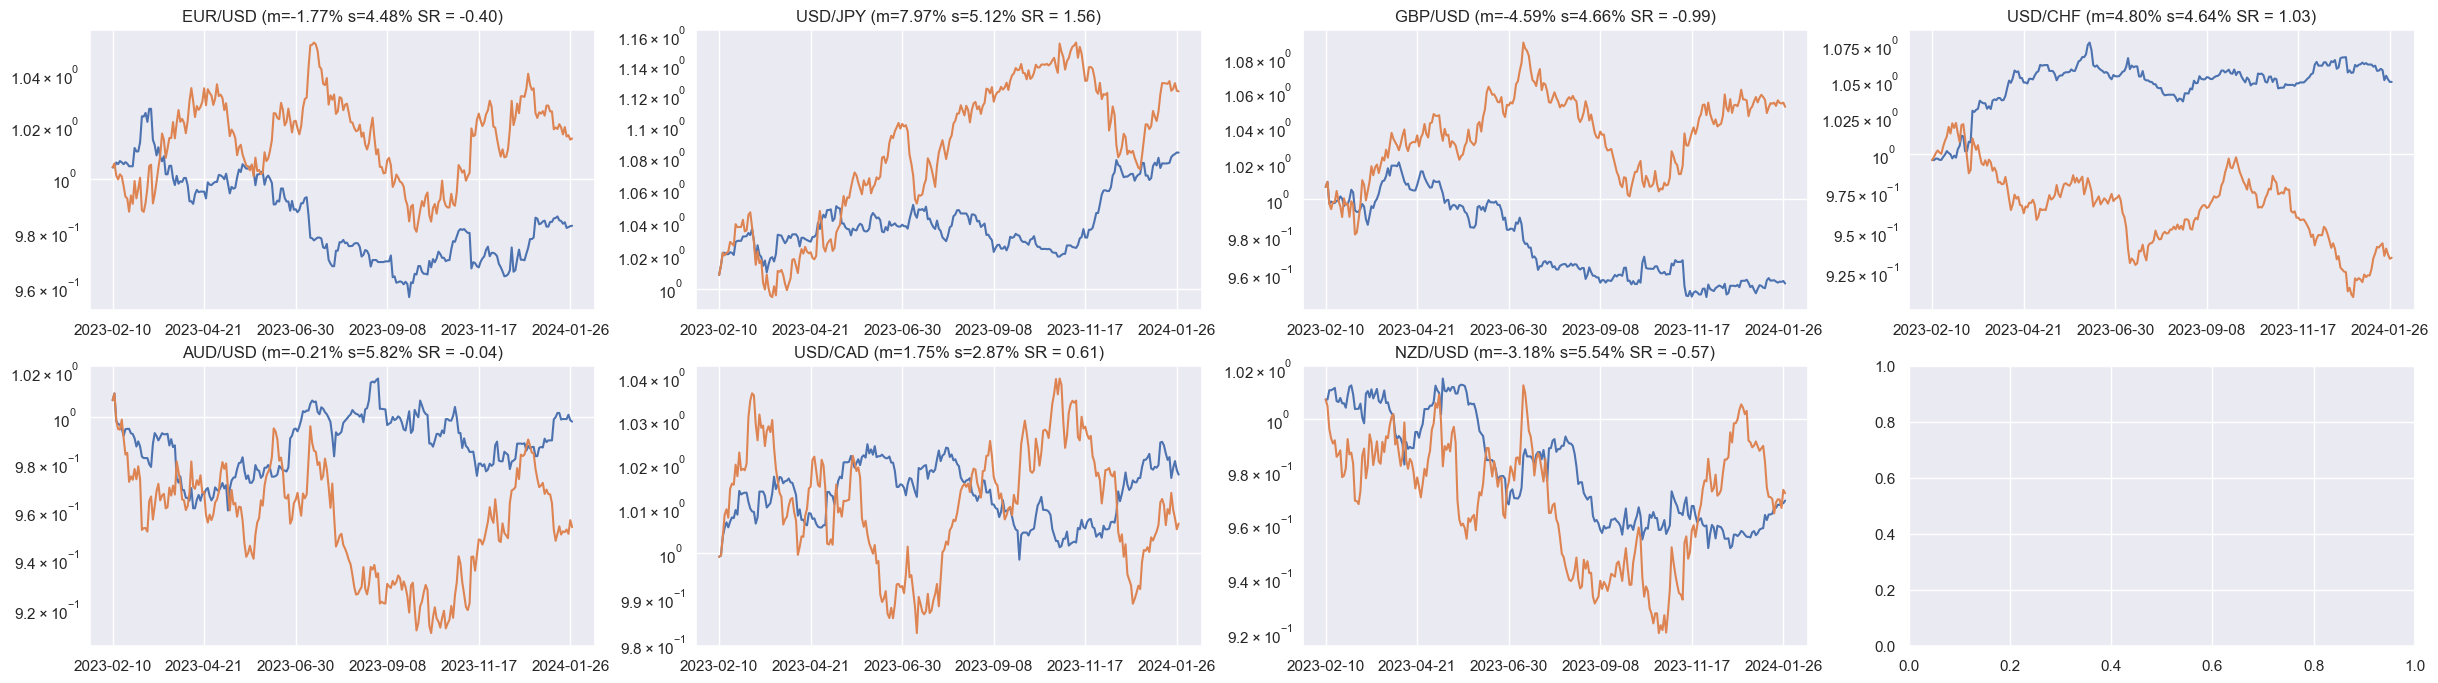

In [94]:
fig,axes = plt.subplots(2,4)
for i,symbol in enumerate(symbols):
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s

    r,c = i//4,i%4
    ax = axes[r,c]

    ax.set_title(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')
    ax.set_yscale('log')
    np.exp(df['Pnl'].cumsum()).plot(ax=ax)
    np.exp(df['Ret'].cumsum()).plot(ax=ax)

    '''
    ax2 = ax.twinx()
    temp = pd.DataFrame({'Long':df['Pos'][df['Pos']>=0],
                         'Short':df['Pos'][df['Pos']<0]})
    ax2.bar(temp.index,temp['Long'],alpha=0.7,color='green')
    ax2.bar(temp.index,temp['Short'],alpha=0.7,color='red')
    '''


In [95]:
test_return = pd.DataFrame()
for symbol in symbols:
    df = test_data[symbol]
    test_return[symbol] = df['Pnl']

### 100 simulations

In [39]:
def perform_test(col):
    train_data = dict()
    test_data = dict()
    frac = round(len(ta_data[symbols[0]]) * 0.2)
    frac = 252
    for symbol in symbols:
        train_data[symbol] = ta_data[symbol].iloc[-frac*6:-frac]
        test_data[symbol] = ta_data[symbol].iloc[-frac:]

    knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
    for i,knn in enumerate(knns):
            bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
            knn.fit(X=bootstrap_train_data.iloc[:,1:],
                    y=np.sign(bootstrap_train_data.iloc[:,0]))
            
    for symbol in symbols:
        df = test_data[symbol]
        pos = pd.DataFrame()
        for i,knn in enumerate(knns):
            pos[f'{i}'] = knn.predict(df.iloc[:,1:])
        df['Pred'] = pos.mean(axis=1).to_numpy()
        df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
        df['Pnl'] = df['Pos'] * df['Ret']
    
    test_return = pd.DataFrame()
    for symbol in symbols:
        df = test_data[symbol]
        test_return[symbol] = df['Pnl']
        port_return = test_return.mean(axis=1) * 100
    
    return port_return

simulated_returns = pd.DataFrame(columns=np.arange(100),index=test_data['AUDUSD=X'].index)
simulated_returns = simulated_returns.apply(perform_test,axis=0)

### Performance

Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=6.83% s=18.67% SR = 0.37)')

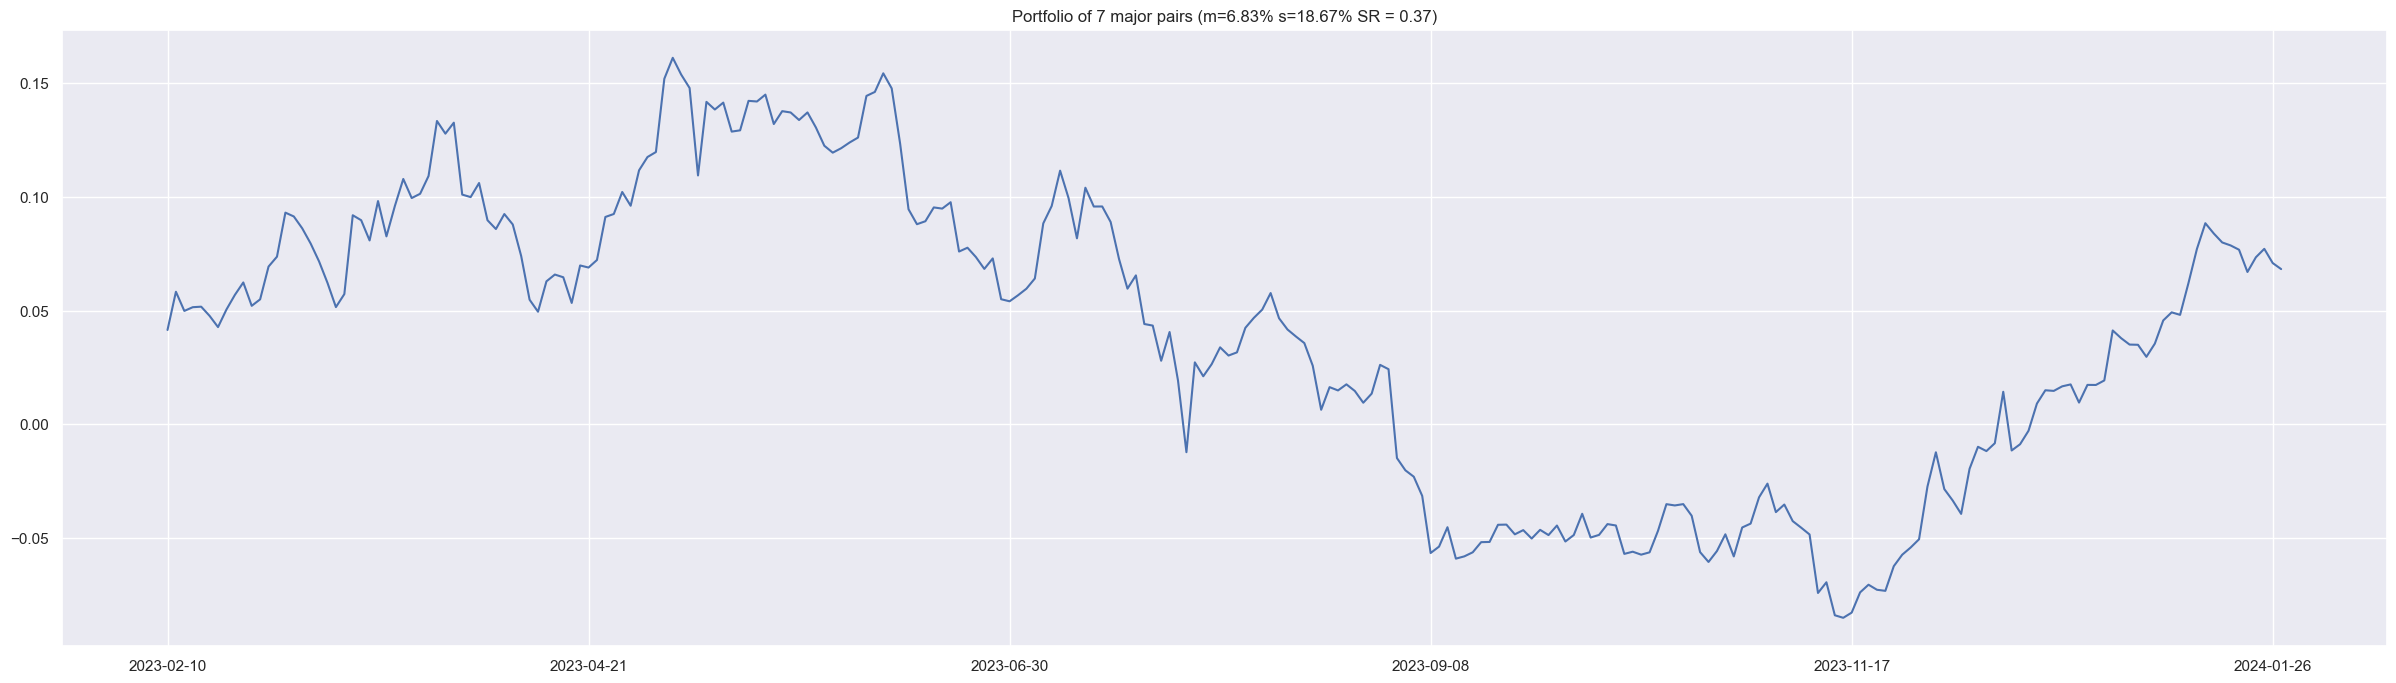

In [96]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1) * 10

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = port_return.cumsum().plot()
#ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [28]:
Evaluator(port_return).get_summary()

ValueError: zero-size array to reduction operation maximum which has no identity

## Walk forward test

### Split datasets

In [117]:
dates = pd.DataFrame()
dates['test_end'] = ta_data[symbols[0]].index[::-252]
dates['test_start'] = dates['test_end'].shift(-1)
dates['train_end'] = dates['test_start']
dates['train_start'] = dates['train_end'].shift(-5)
dates = dates.loc[dates.index[::-1]].iloc[6:].reset_index(drop=True)

train_data_list = list()
test_data_list = list()
for i in range(len(dates)):
    train_data = dict()
    test_data = dict()

    print(f'{i}-th dataset:')

    for symbol in symbols:
        train_start, train_end = dates.loc[i,'train_start'], dates.loc[i,'train_end']
        test_start, test_end = dates.loc[i,'test_start'], dates.loc[i,'test_end']

        train = ta_data[symbol].loc[train_start:train_end]
        test = ta_data[symbol].loc[test_start:test_end].iloc[1:]

        train_data[symbol] = train
        test_data[symbol] = test
        #print(f'{symbol} {i}-th dataset: trained {train_start.date()} to {train_end.date()}, tested {test_start.date()} to {test_end.date()}')

        

        try:
            train_start_date = train.index[0].date()
            train_end_date = train.index[-1].date()
        except:
            train_start_date = '{NO DATA}'
            train_end_date = '{NO DATA}'

        try:
            test_start_date = test.index[0].date()
            test_end_date = test.index[-1].date()
        except:
            test_start_date = '{NO DATA}'
            test_end_date = '{NO DATA}'

        print(f'    {symbol} [{len(train)},{len(test)}]: trained {train_start_date} to {train_end_date}, tested {test_start_date} to {test_end_date}')

    train_data_list.append(train_data)
    test_data_list.append(test_data)

    print()

0-th dataset:
    EUR/USD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/JPY [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    GBP/USD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CHF [1260,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUD/USD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CAD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    NZD/USD [1260,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}

1-th dataset:
    EUR/USD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/JPY [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    GBP/USD [1261,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CHF [1260,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUD/USD [1261,252]: t

### Walk-forward testing

In [111]:
knns_list = list()
for i,train_data in enumerate(train_data_list):
    print(f'Training {i}-th dataset')
    #print(train_data.keys())
    concat_train_data = pd.concat(train_data.values())
    knns = [KNeighborsClassifier(n_neighbors=20) for _ in range(100)]
    for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=1,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
            y=np.sign(bootstrap_train_data.iloc[:,0]))
    knns_list.append(knns)

Training 0-th dataset
Training 1-th dataset
Training 2-th dataset
Training 3-th dataset
Training 4-th dataset
Training 5-th dataset
Training 6-th dataset
Training 7-th dataset
Training 8-th dataset
Training 9-th dataset
Training 10-th dataset
Training 11-th dataset
Training 12-th dataset


In [114]:
for i,(test_data,knns) in enumerate(zip(test_data_list,knns_list)):
    print(f'Trading {i}-th dataset')
    for symbol in symbols:
        df = test_data[symbol]
        pos = pd.DataFrame()
        if len(df) > 0:
            for i,knn in enumerate(knns):
                pos[f'{i}'] = knn.predict(df.iloc[:,1:])
            df['Pred'] = pos.mean(axis=1).to_numpy()
            df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
            #df['Pos'] = np.around(df['Pred']*5)/5
            df['Pnl'] = df['Pos'] * df['Ret']

Trading 0-th dataset
Trading 1-th dataset
Trading 2-th dataset
Trading 3-th dataset
Trading 4-th dataset
Trading 5-th dataset
Trading 6-th dataset
Trading 7-th dataset
Trading 8-th dataset
Trading 9-th dataset
Trading 10-th dataset
Trading 11-th dataset
Trading 12-th dataset


### Performance

In [115]:
test_return_list = list()
for i,test_data in enumerate(test_data_list):
    test_return = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_return[symbol] = test_data[symbol]['Pnl']
    test_return['Port'] = test_return.mean(axis=1)
    test_return_list.append(test_return)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=-0.77% s=2.09% SR = -0.37)')

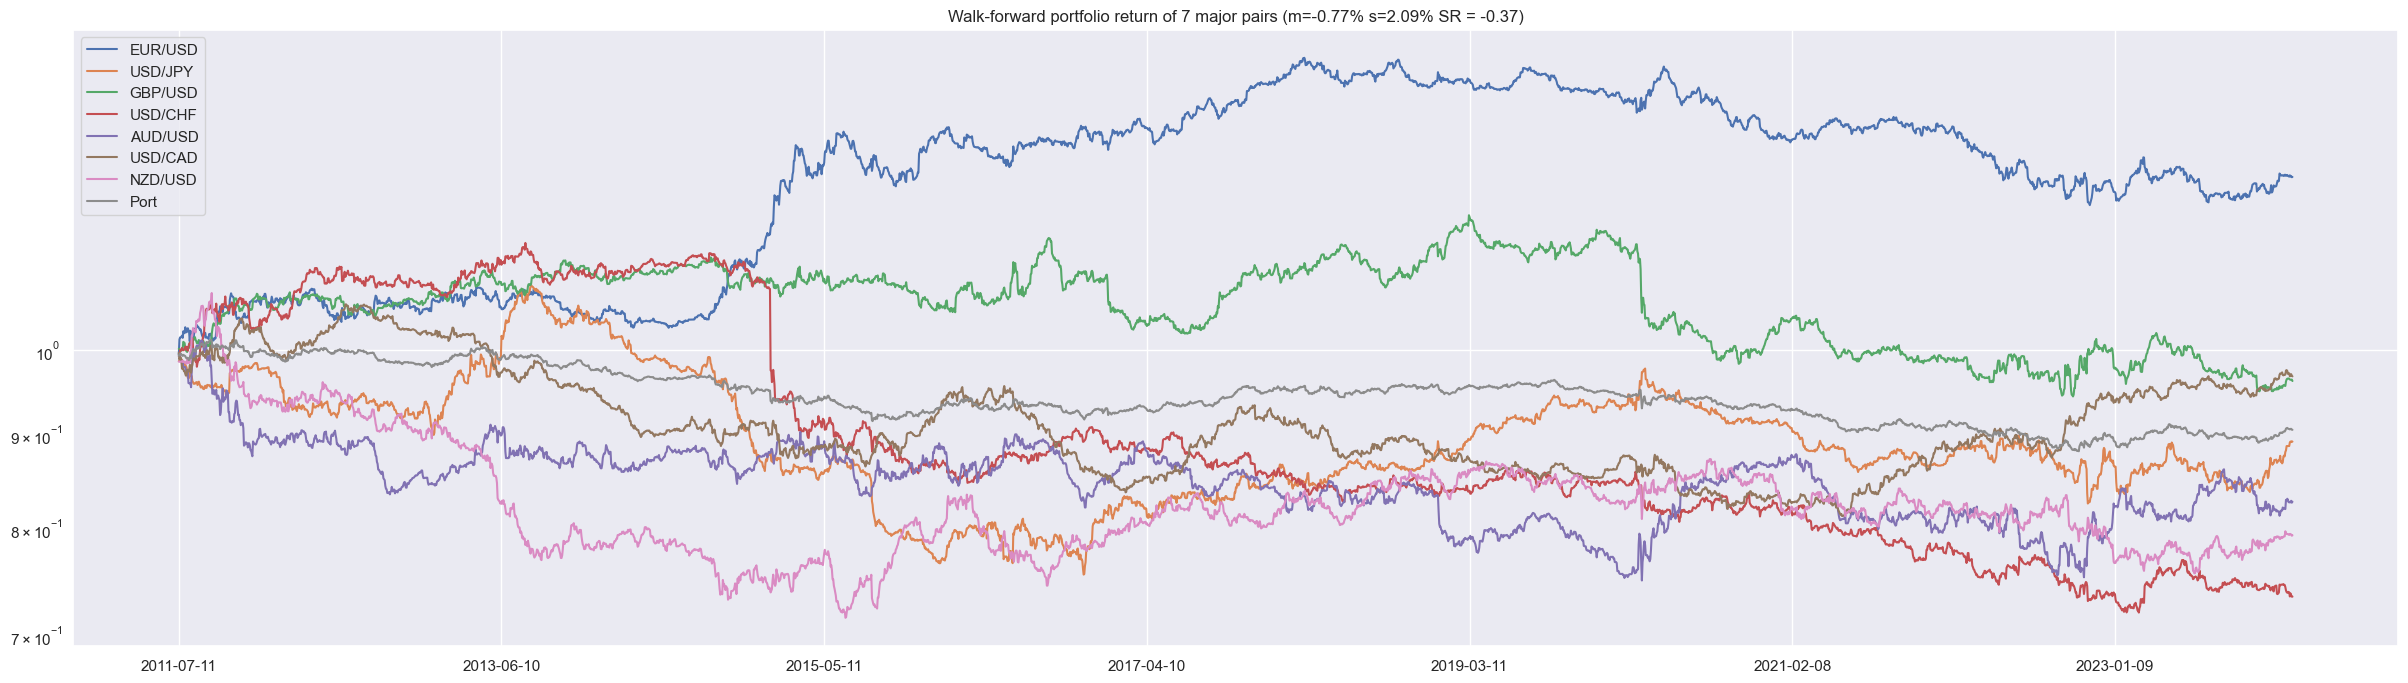

In [116]:
concat_test_return = pd.concat(test_return_list,axis=0)

ax = np.exp(concat_test_return.cumsum()).plot()
ax.set_yscale('log')

m = concat_test_return['Port'].mean()*252
s = concat_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [39]:
Evaluator(concat_test_return['Port']).get_summary()

ValueError: zero-size array to reduction operation maximum which has no identity

<Axes: >

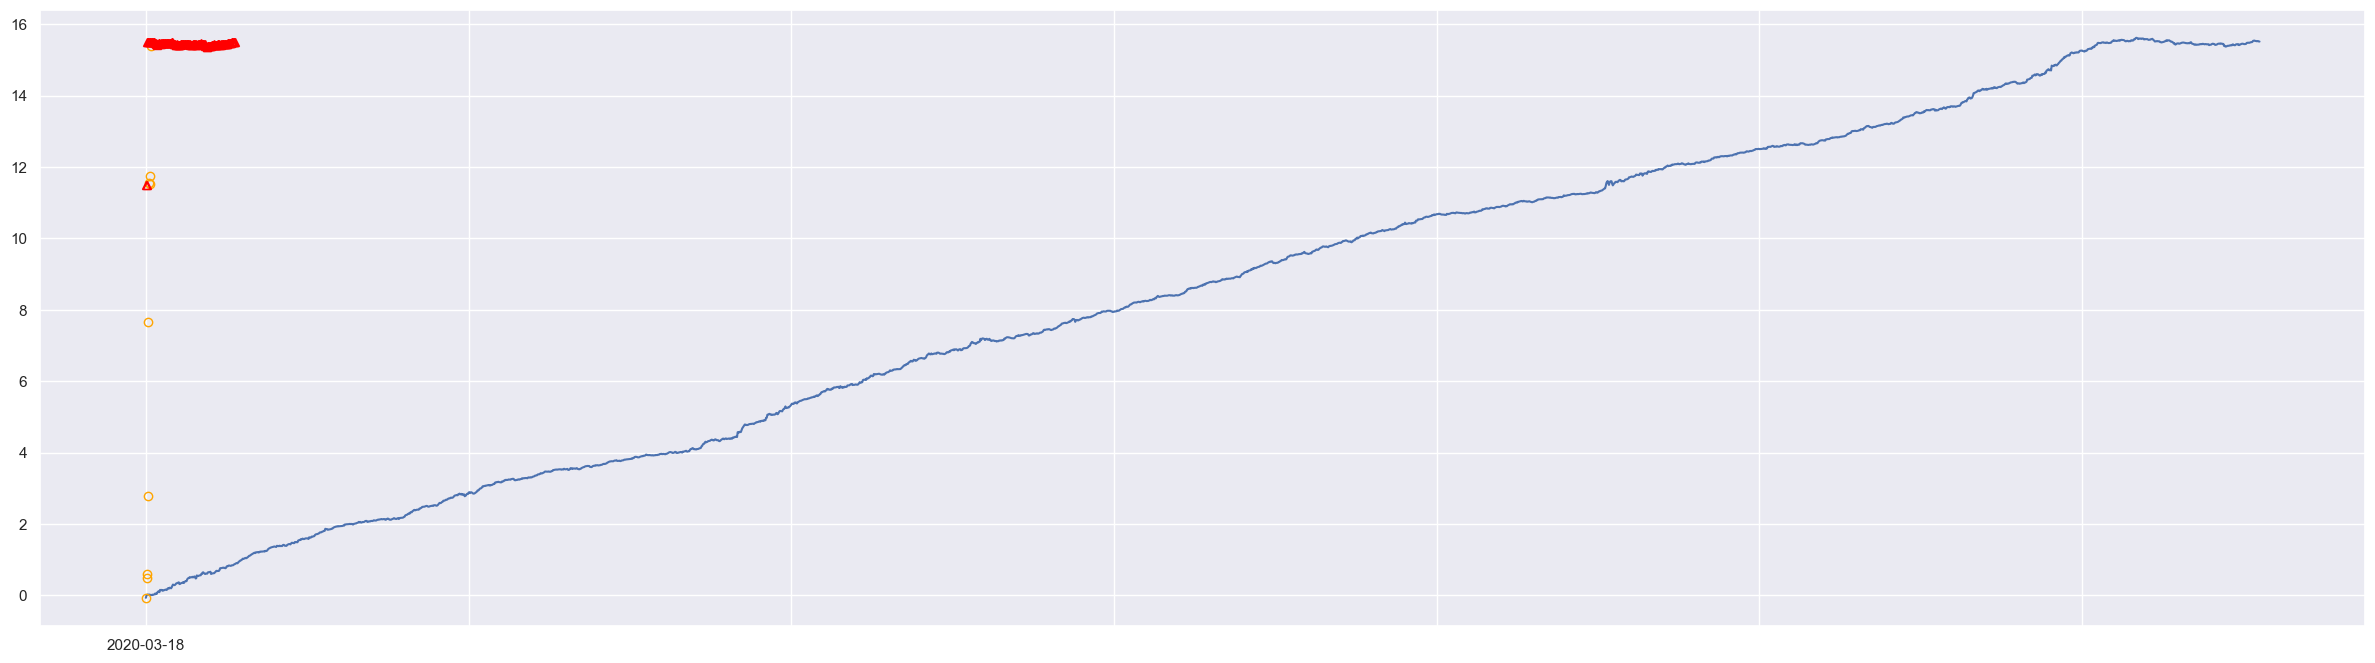

In [41]:
port_return = concat_test_return['Port']*10
cum_return = (port_return.cumsum())
cum_loss = cum_return - cum_return.cummax()

ax = cum_return.plot()
cum_return[port_return<-0.05].plot(marker='o',linestyle='None',markeredgecolor='orange',color='None')
cum_return[cum_loss<-0.10].plot(marker='^',linestyle='None',markeredgecolor='red',color='None')

<Axes: ylabel='Frequency'>

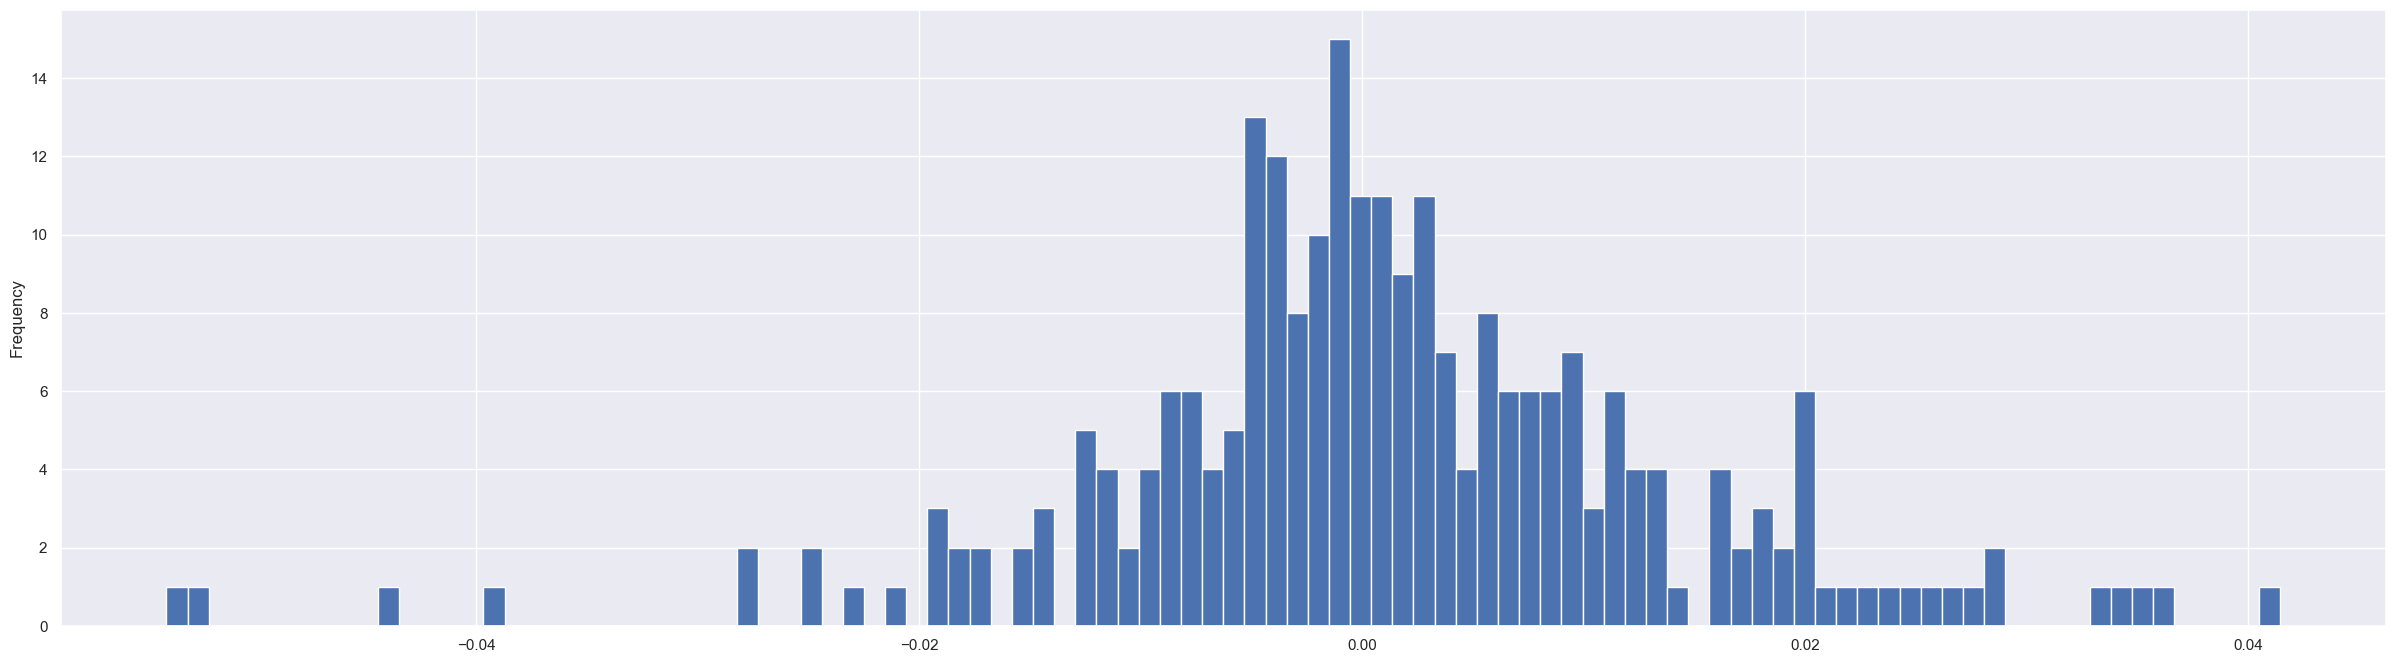

In [40]:
port_return.plot(kind='hist',bins=100)

In [212]:
cum_loss[cum_loss<0].quantile(0.01)

-0.29350489558636783

In [213]:
port_return[port_return<-0.05].count()

10

In [148]:
cum_loss[cum_loss<-0.10].count()

203

In [214]:
m = concat_test_return.mean()*252
s = concat_test_return.std()*np.sqrt(252)
SR = m/s
pd.DataFrame({'Mean':m,
              'Vol':s,
              'SR':SR})

,Mean,Vol,SR
EUR/USD,0.0932,0.0478,1.9501
USD/JPY,0.1014,0.0533,1.9012
GBP/USD,0.0888,0.0531,1.6741
USD/CHF,0.0653,0.0501,1.3048
AUD/USD,0.1032,0.0638,1.6162
USD/CAD,0.0815,0.0419,1.9445
NZD/USD,0.1061,0.0617,1.7207
Port,0.0914,0.0219,4.1800


<Axes: title={'center': 'Rolling 1-year SR'}>

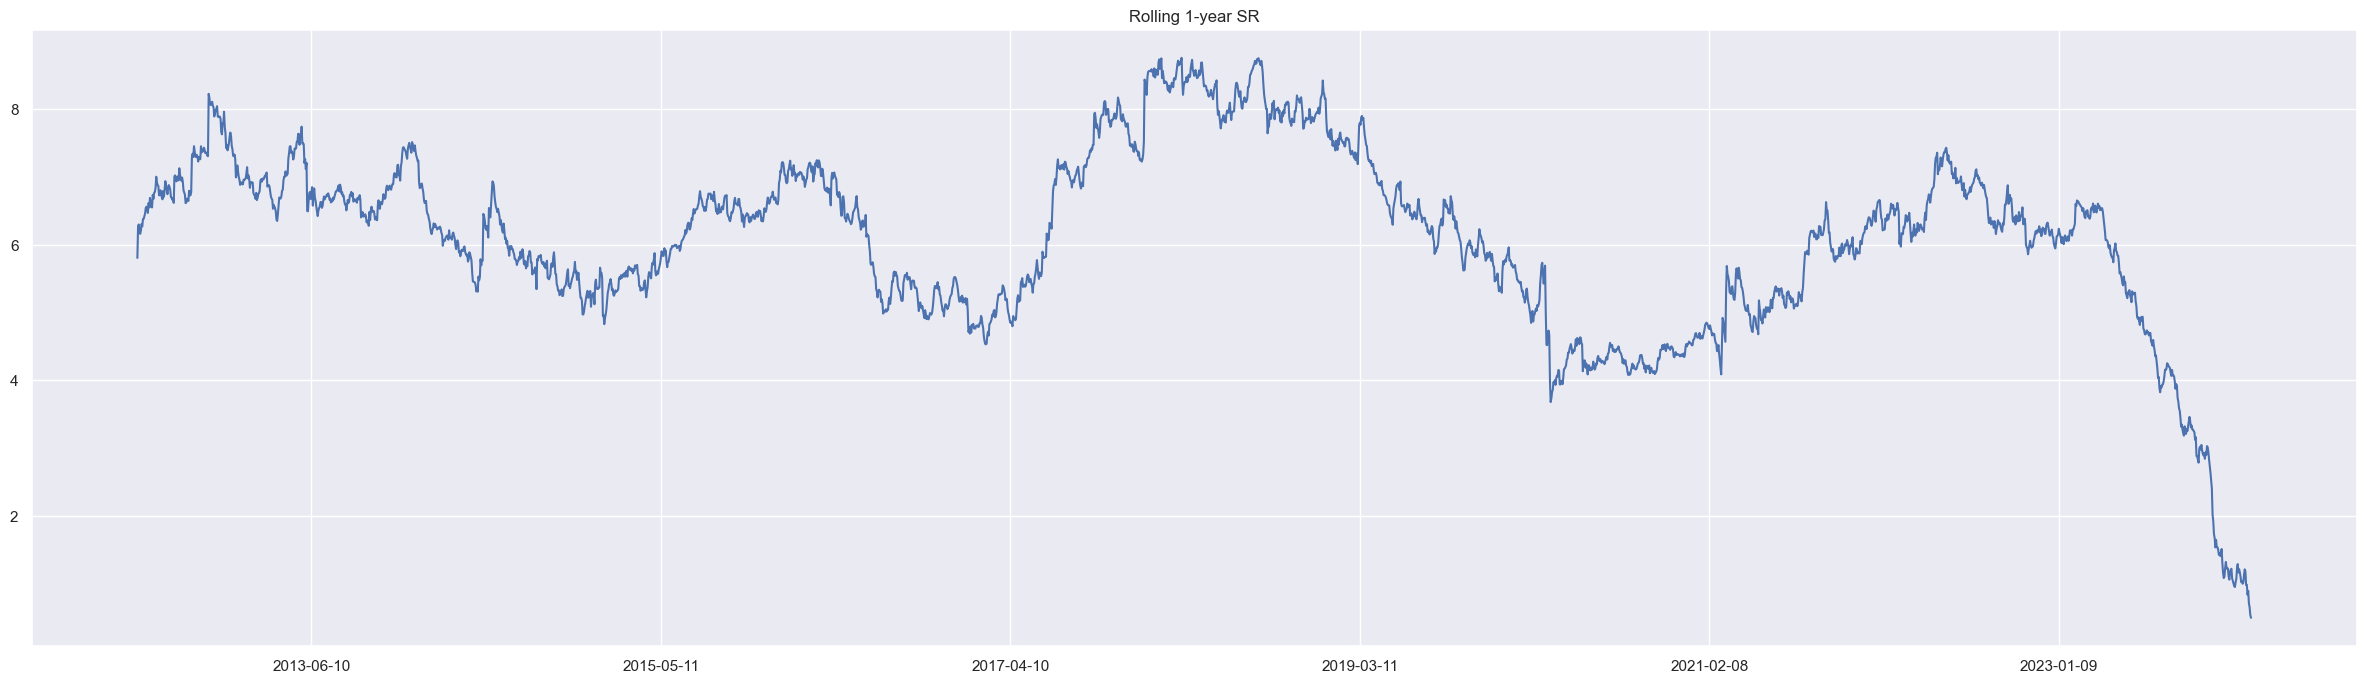

In [51]:
i = 1

m = concat_test_return['Port'].rolling(252*i).mean() * 252
s = concat_test_return['Port'].rolling(252*i).std() * np.sqrt(252)
SR = m/s

SR.plot(title=f'Rolling {i}-year SR')

### Net cost

In [82]:
test_pos_list = list()
test_pred_list = list()
for i,test_data in enumerate(test_data_list):
    test_pos = pd.DataFrame()
    test_pred = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_pos[symbol] = test_data[symbol]['Pos']
            test_pred[symbol] = (np.sign(test_data[symbol]['Pred']) == np.sign(test_data[symbol]['Ret']))
    test_pos_list.append(test_pos)
    test_pred_list.append(test_pred)

In [292]:
spread = 0.0001

concat_test_pos = pd.concat(test_pos_list,axis=0)
cost = concat_test_pos.diff() * spread

netcost_test_return = concat_test_return - cost
netcost_test_return['Port'] = netcost_test_return.mean(axis=1)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=16.93% s=3.26% SR = 5.19)')

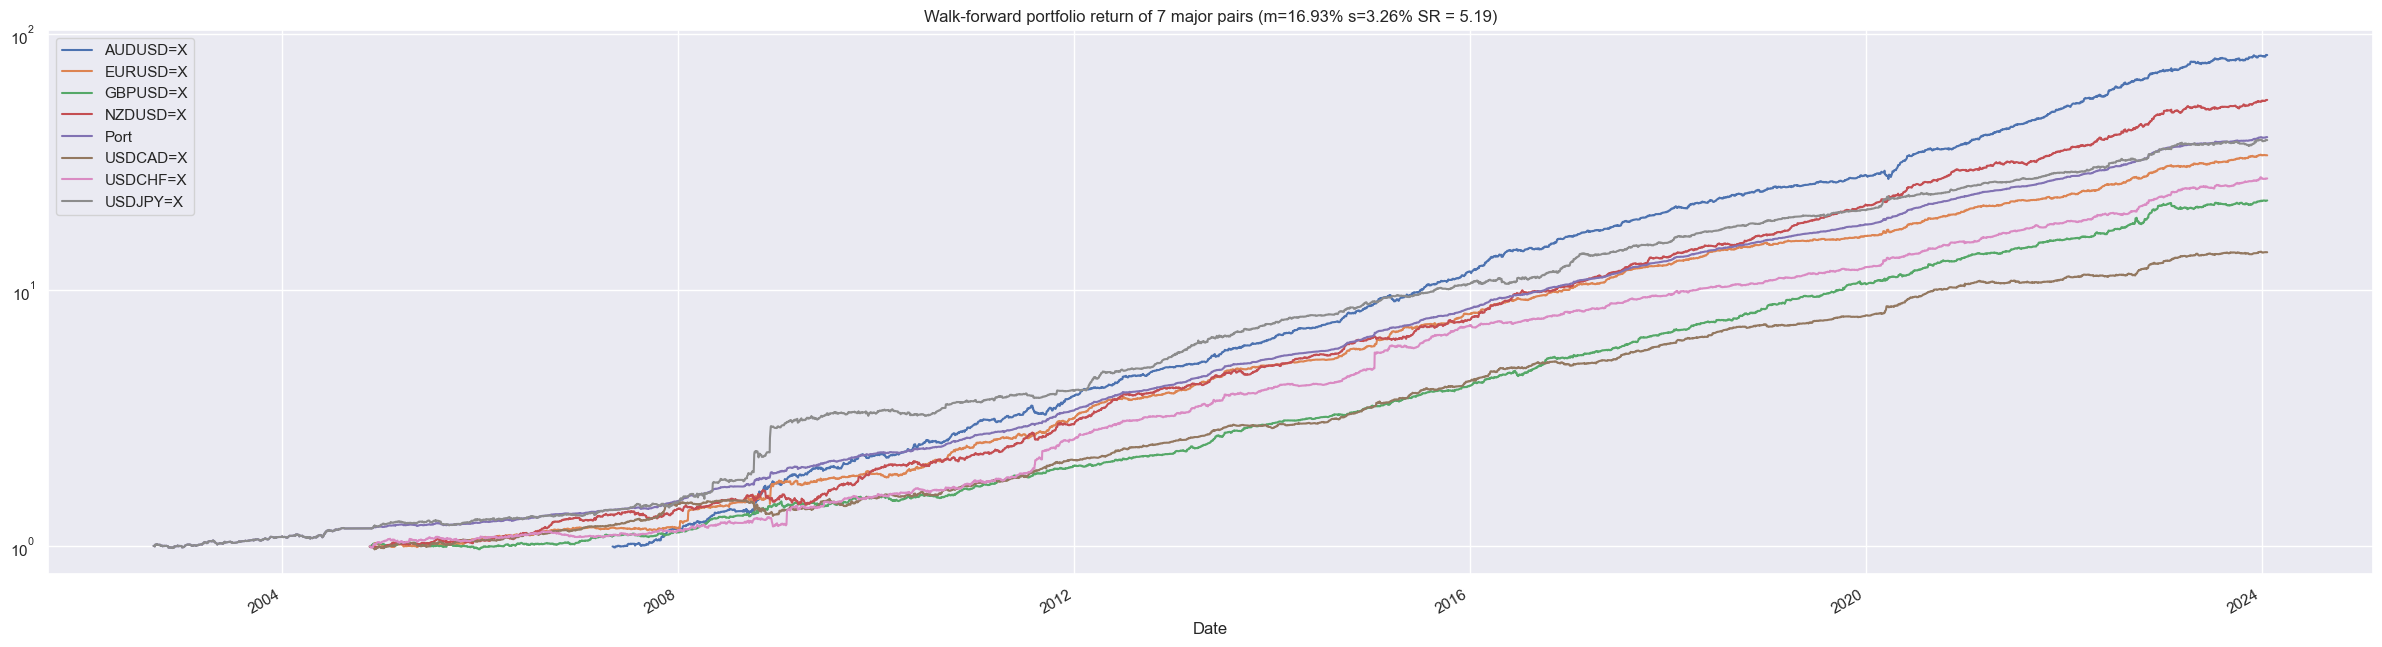

In [293]:
ax = np.exp(netcost_test_return.cumsum()).plot()
ax.set_yscale('log')

m = netcost_test_return['Port'].mean()*252
s = netcost_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

# RF Model

## 2-dataset test

In [152]:
train_data = dict()
test_data = dict()
#frac = round(len(ta_data[symbols[0]]) * 0.2)
frac = 252
for symbol in symbols:
    train_data[symbol] = ta_data[symbol].iloc[:-frac]
    test_data[symbol] = ta_data[symbol].iloc[-frac:]

In [153]:
concat_train_data = pd.concat(train_data.values())

### Backtesting

In [154]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X=concat_train_data.iloc[:,1:],
       y=np.sign(concat_train_data.iloc[:,0]))

RandomForestClassifier()

In [155]:
for symbol in symbols:
    df = test_data[symbol]
    df['Pred'] = rf.predict(df.iloc[:,1:])
    #df['Pred'] = df['Pred'].ewm(21).mean()
    df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
    df['Pnl'] = df['Pos'] * df['Ret']

C:\Users\benka\AppData\Local\Temp\ipykernel_7196\575515386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = rf.predict(df.iloc[:,1:])
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\575515386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\575515386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [156]:
for symbol in symbols:
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s
    print(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

EUR/USD (m=-1.91% s=3.59% SR = -0.53)
USD/JPY (m=2.59% s=4.77% SR = 0.54)
GBP/USD (m=-3.08% s=3.92% SR = -0.79)
USD/CHF (m=-1.23% s=4.01% SR = -0.31)
AUD/USD (m=-3.89% s=4.73% SR = -0.82)
USD/CAD (m=-0.87% s=2.76% SR = -0.32)
NZD/USD (m=9.70% s=4.57% SR = 2.12)


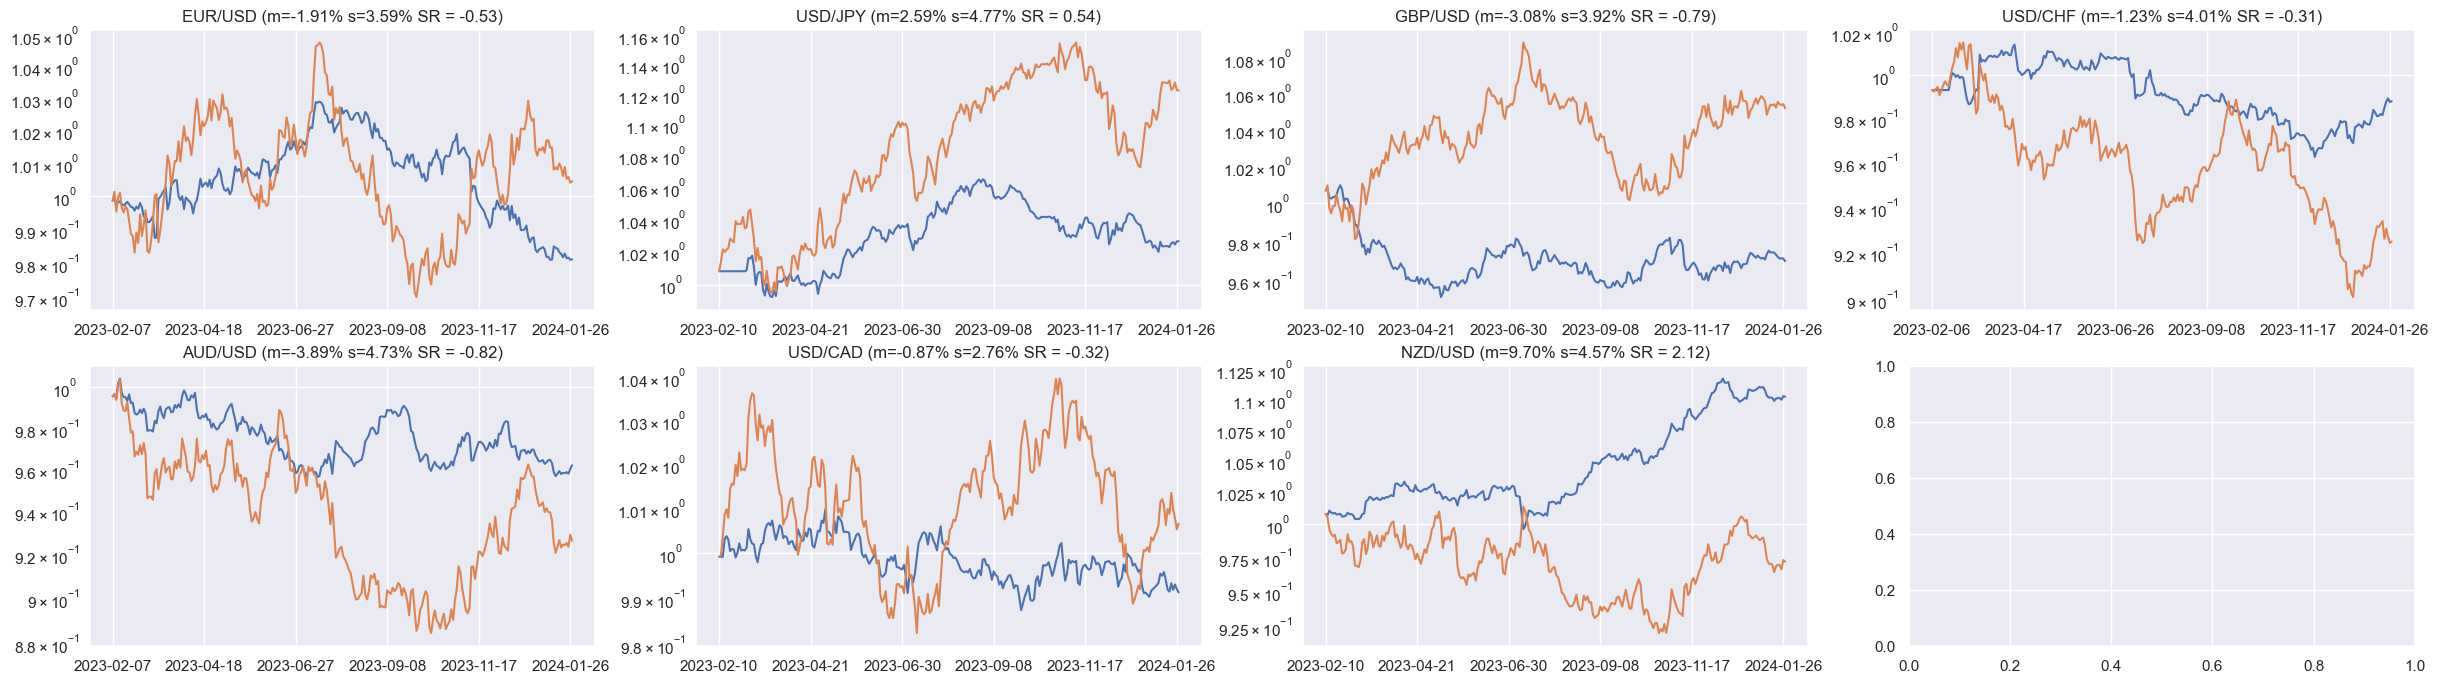

In [157]:
fig,axes = plt.subplots(2,4)
for i,symbol in enumerate(symbols):
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s

    r,c = i//4,i%4
    ax = axes[r,c]

    ax.set_title(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')
    ax.set_yscale('log')
    np.exp(df['Pnl'].cumsum()).plot(ax=ax)
    np.exp(df['Ret'].cumsum()).plot(ax=ax)

    '''
    ax2 = ax.twinx()
    temp = pd.DataFrame({'Long':df['Pos'][df['Pos']>=0],
                         'Short':df['Pos'][df['Pos']<0]})
    ax2.bar(temp.index,temp['Long'],alpha=0.7,color='green')
    ax2.bar(temp.index,temp['Short'],alpha=0.7,color='red')
    '''

In [158]:
test_return = pd.DataFrame()
for symbol in symbols:
    df = test_data[symbol]
    test_return[symbol] = df['Pnl']

### Performance

Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=0.95% s=16.49% SR = 0.06)')

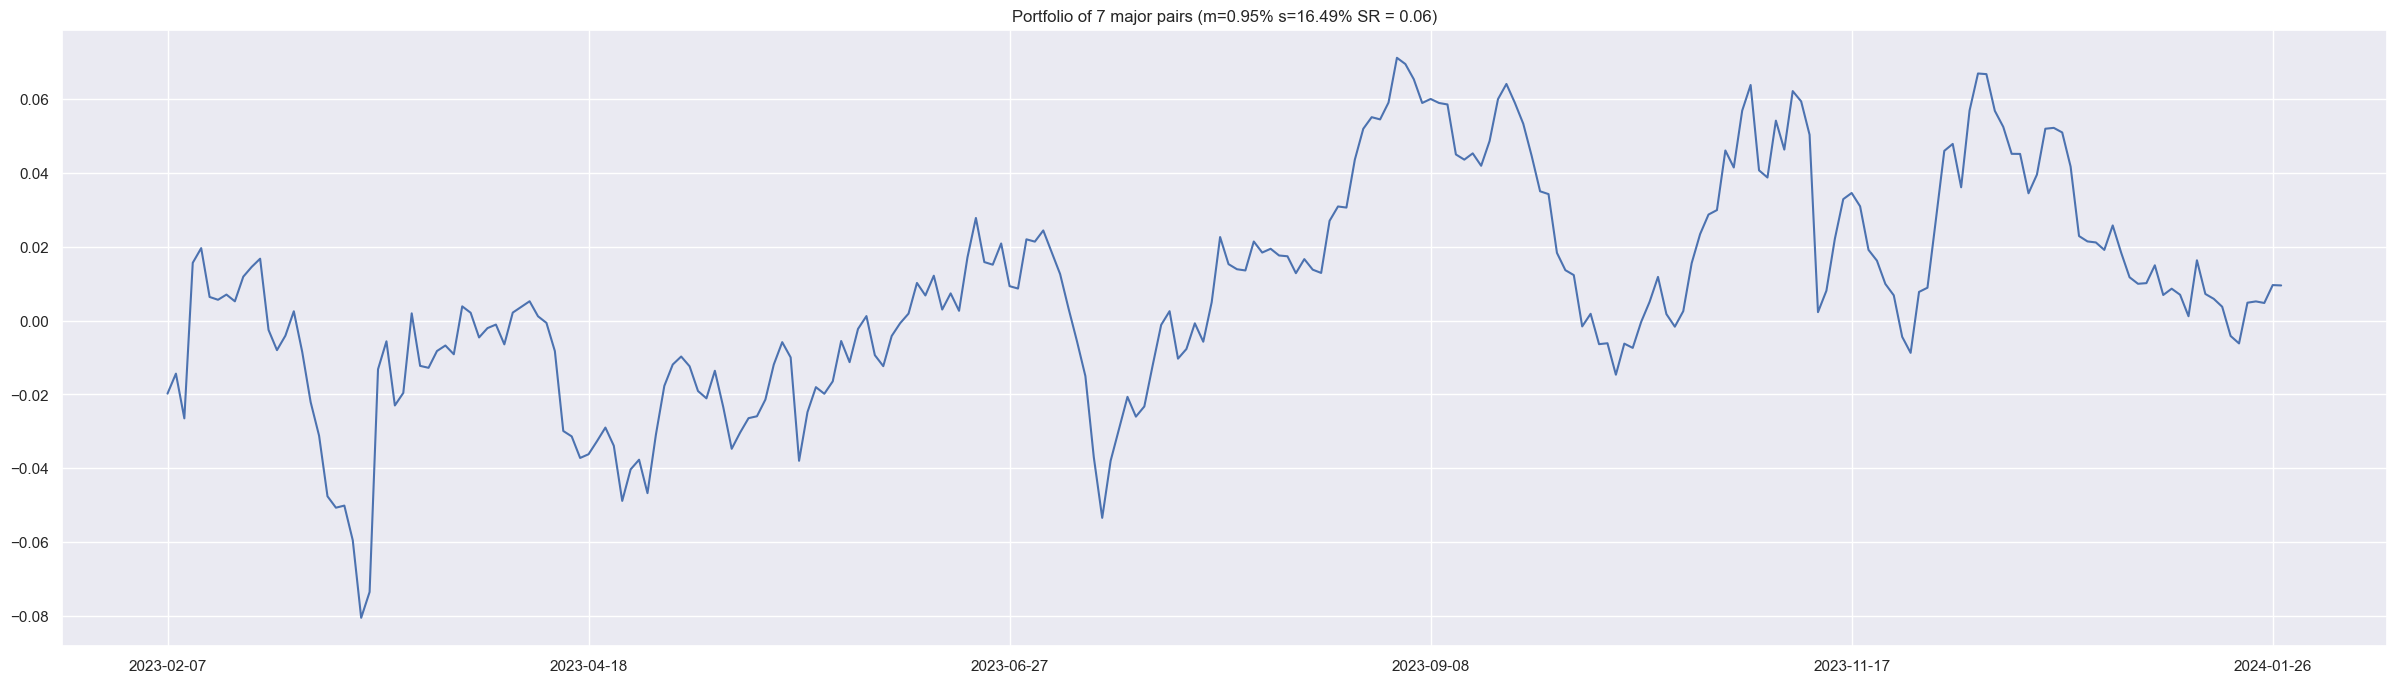

In [159]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1) * 10

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = port_return.cumsum().plot()
#ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

## Walk forward test

### Split datasets

In [165]:
dates = pd.DataFrame()
dates['test_end'] = ta_data[symbols[0]].index[::-252]
dates['test_start'] = dates['test_end'].shift(-1)
dates['train_end'] = dates['test_start']
dates['train_start'] = dates['train_end'].shift(-5)
dates = dates.loc[dates.index[::-1]].iloc[6:].reset_index(drop=True)

train_data_list = list()
test_data_list = list()
for i in range(len(dates)):
    train_data = dict()
    test_data = dict()

    print(f'{i}-th dataset:')

    for symbol in symbols:
        train_start, train_end = dates.loc[i,'train_start'], dates.loc[i,'train_end']
        test_start, test_end = dates.loc[i,'test_start'], dates.loc[i,'test_end']

        train = ta_data[symbol].loc[:train_end]
        test = ta_data[symbol].loc[test_start:test_end].iloc[1:]

        train_data[symbol] = train
        test_data[symbol] = test
        #print(f'{symbol} {i}-th dataset: trained {train_start.date()} to {train_end.date()}, tested {test_start.date()} to {test_end.date()}')

        

        try:
            train_start_date = train.index[0].date()
            train_end_date = train.index[-1].date()
        except:
            train_start_date = '{NO DATA}'
            train_end_date = '{NO DATA}'

        try:
            test_start_date = test.index[0].date()
            test_end_date = test.index[-1].date()
        except:
            test_start_date = '{NO DATA}'
            test_end_date = '{NO DATA}'

        print(f'    {symbol} [{len(train)},{len(test)}]: trained {train_start_date} to {train_end_date}, tested {test_start_date} to {test_end_date}')

    train_data_list.append(train_data)
    test_data_list.append(test_data)

    print()

0-th dataset:
    EUR/USD [1321,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/JPY [1323,248]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    GBP/USD [1327,257]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CHF [1320,257]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUD/USD [1320,254]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CAD [1331,254]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    NZD/USD [1313,251]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}

1-th dataset:
    EUR/USD [1573,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/JPY [1571,252]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    GBP/USD [1584,255]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USD/CHF [1577,246]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUD/USD [1574,252]: t

### Walkforward testing

In [161]:
rf_list = list()
for i,train_data in enumerate(train_data_list):
    print(f'Training {i}-th dataset')
    #print(train_data.keys())
    concat_train_data = pd.concat(train_data.values())

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X=concat_train_data.iloc[:,1:],
        y=np.sign(concat_train_data.iloc[:,0]))
    rf_list.append(rf)

Training 0-th dataset
Training 1-th dataset
Training 2-th dataset
Training 3-th dataset
Training 4-th dataset
Training 5-th dataset
Training 6-th dataset
Training 7-th dataset
Training 8-th dataset
Training 9-th dataset
Training 10-th dataset
Training 11-th dataset
Training 12-th dataset


In [166]:
for i,(test_data,rf) in enumerate(zip(test_data_list,rf_list)):
    print(f'Trading {i}-th dataset')

    for symbol in symbols:
        df = test_data[symbol]
        df['Pred'] = rf.predict(df.iloc[:,1:])
        df['Pred'] = (df['Pred'].ewm(21).mean())
        df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
        df['Pnl'] = df['Pos'] * df['Ret']

Trading 0-th dataset
Trading 1-th dataset
Trading 2-th dataset
Trading 3-th dataset
Trading 4-th dataset
Trading 5-th dataset
Trading 6-th dataset
Trading 7-th dataset
Trading 8-th dataset
Trading 9-th dataset
Trading 10-th dataset
Trading 11-th dataset
Trading 12-th dataset


### Performance

In [167]:
test_return_list = list()
for i,test_data in enumerate(test_data_list):
    test_return = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_return[symbol] = test_data[symbol]['Pnl']
    test_return['Port'] = test_return.mean(axis=1)
    test_return_list.append(test_return)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=0.47% s=2.29% SR = 0.20)')

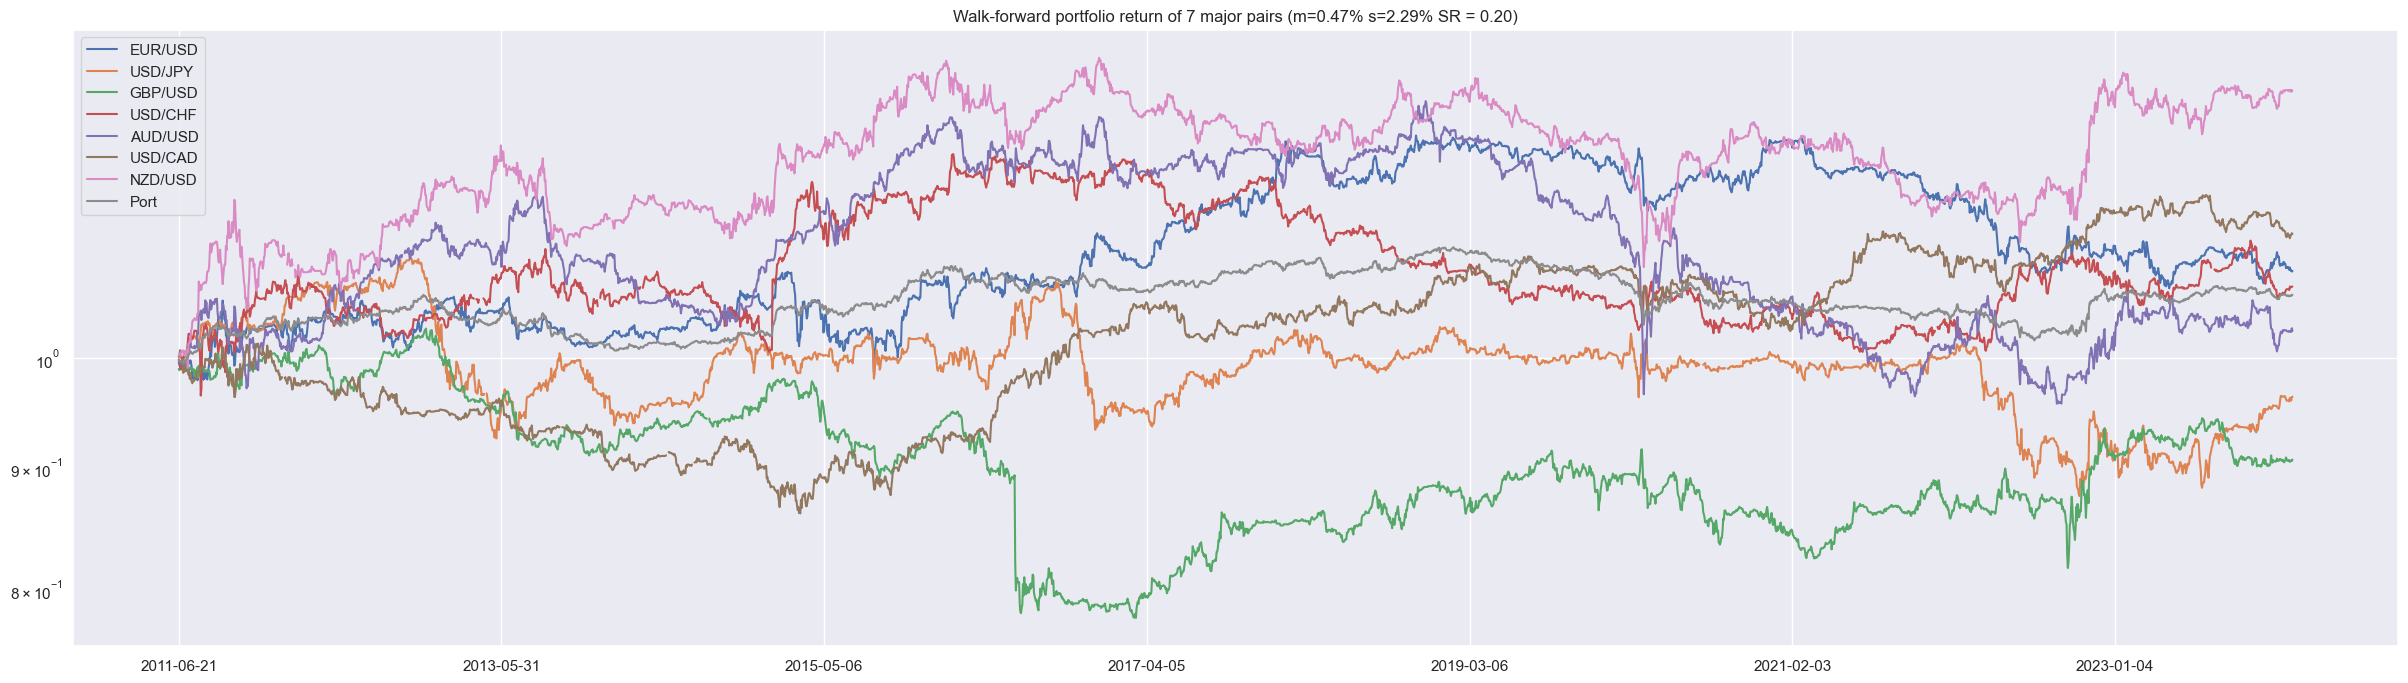

In [168]:
concat_test_return = pd.concat(test_return_list,axis=0)

ax = np.exp(concat_test_return.cumsum()).plot()
ax.set_yscale('log')

m = concat_test_return['Port'].mean()*252
s = concat_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [169]:
Evaluator(concat_test_return['Port']).get_summary()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
port_return = concat_test_return['Port']*10
cum_return = (port_return.cumsum())
cum_loss = cum_return - cum_return.cummax()

ax = cum_return.plot()
cum_return[port_return<-0.05].plot(marker='o',linestyle='None',markeredgecolor='orange',color='None')
cum_return[cum_loss<-0.10].plot(marker='^',linestyle='None',markeredgecolor='red',color='None')

# Trend-following with ML

In [202]:
train_data = dict()
test_data = dict()
#frac = round(len(ta_data[symbols[0]]) * 0.2)
frac = 252
for symbol in symbols:
    train_data[symbol] = ta_data[symbol].iloc[:-frac]
    test_data[symbol] = ta_data[symbol].iloc[-frac:]

In [191]:
def label_speed(row):
    if row['Pnl_5'] > row['Pnl_10']:
        return 5
    elif row['Pnl_10'] > row['Pnl_21']:
        return 10
    elif row['Pnl_21'] > row['Pnl_63']:
        return 21
    else:
        return 63

In [192]:
for symbol in symbols:
    train = train_data[symbol]
    train['Pnl_5'] = (train['BBL_5'] * train['Ret']).fillna(0)
    train['Pnl_10'] = (train['BBL_10'] * train['Ret']).fillna(0)
    train['Pnl_21'] = (train['BBL_21'] * train['Ret']).fillna(0)
    train['Pnl_63'] = (train['BBL_63'] * train['Ret']).fillna(0)
    train['Speed'] = train.apply(label_speed,axis=1)
    train.drop(columns=['Pnl_5','Pnl_10','Pnl_21','Pnl_63'],inplace=True)

C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1661487312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Pnl_5'] = (train['BBL_5'] * train['Ret']).fillna(0)
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1661487312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Pnl_10'] = (train['BBL_10'] * train['Ret']).fillna(0)
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\1661487312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [193]:
concat_train_data = pd.concat(train_data.values())

In [194]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X=concat_train_data.drop(columns=['Speed','Ret']),
       y=concat_train_data['Speed'])

RandomForestClassifier()

In [200]:
def get_speed(row):
    speed = int(row['Pred'])
    return max(row[f'BBL_{speed}'],2)

In [203]:
for symbol in symbols:
    df = test_data[symbol]
    df['Pred'] = rf.predict(df.drop(columns='Ret'))
    df['Pos'] = df.apply(get_speed,axis=1)
    df['Pnl'] = df['Pos'] * df['Ret']

C:\Users\benka\AppData\Local\Temp\ipykernel_7196\395979183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = rf.predict(df.drop(columns='Ret'))
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\395979183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = df.apply(get_speed,axis=1)
C:\Users\benka\AppData\Local\Temp\ipykernel_7196\395979183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [204]:
for symbol in symbols:
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s
    print(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

EUR/USD (m=0.90% s=14.11% SR = 0.06)
USD/JPY (m=23.12% s=18.17% SR = 1.27)
GBP/USD (m=10.06% s=15.37% SR = 0.65)
USD/CHF (m=-38.61% s=37.14% SR = -1.04)
AUD/USD (m=-115.32% s=61.10% SR = -1.89)
USD/CAD (m=1.32% s=11.07% SR = 0.12)
NZD/USD (m=-87.87% s=74.15% SR = -1.19)


Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=-3.20% s=15.86% SR = -0.20)')

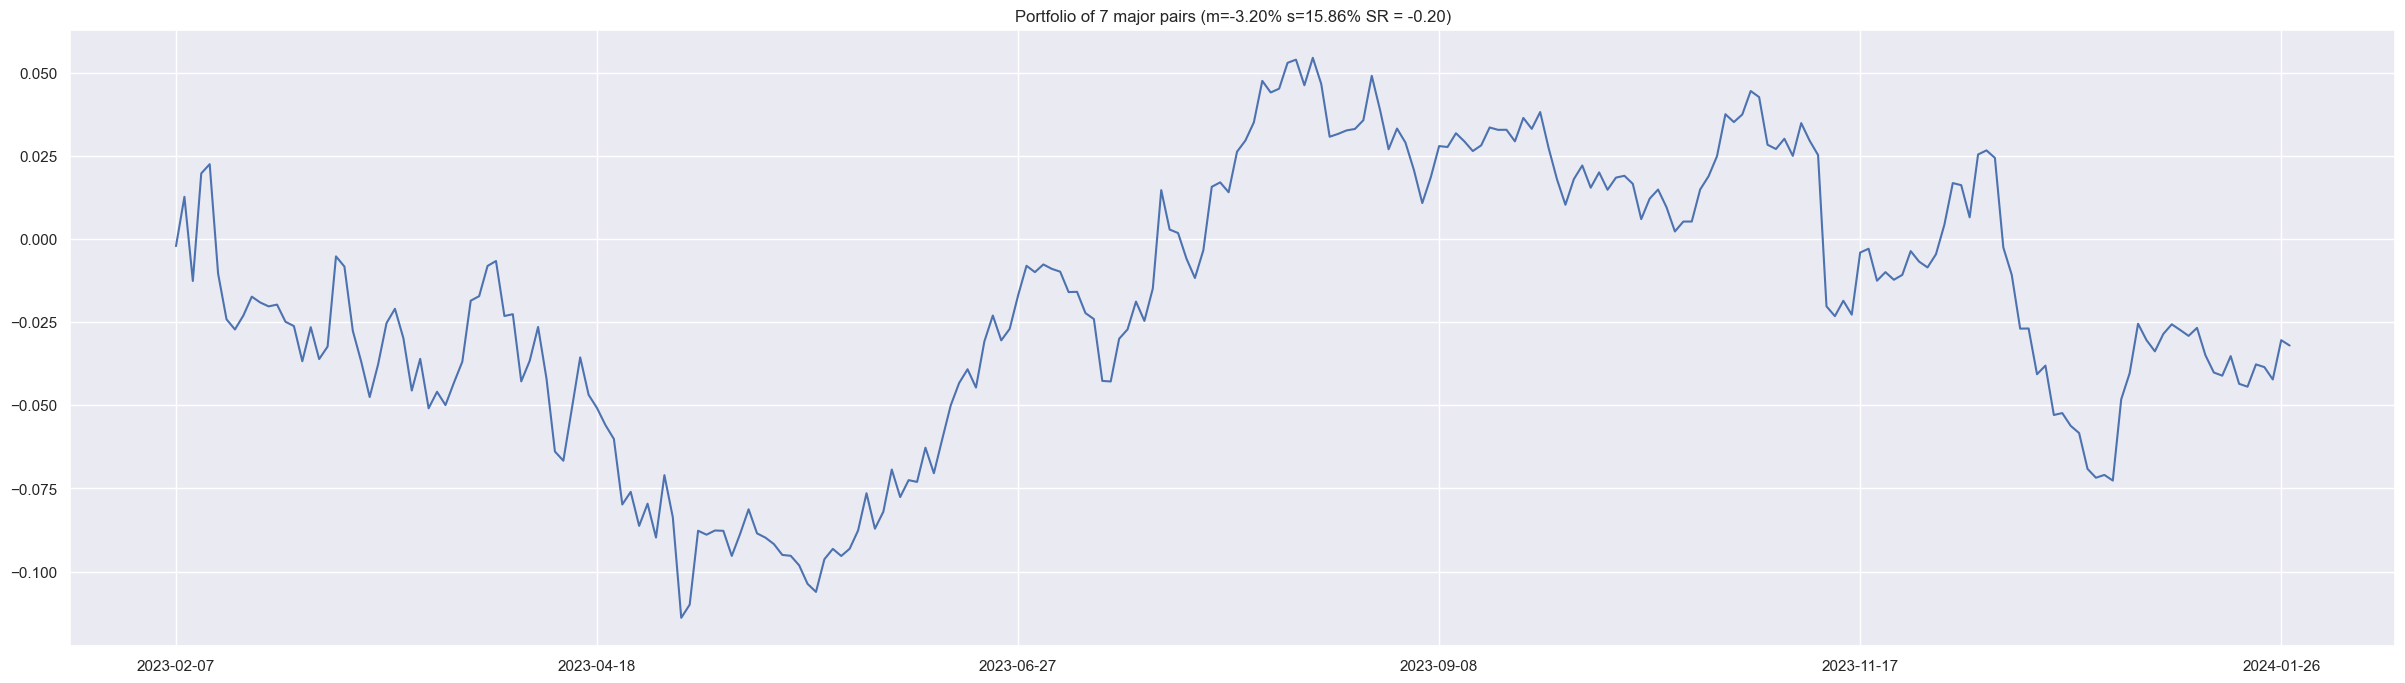

In [205]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1) * 10

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = port_return.cumsum().plot()
#ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')